In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import json
import warnings
from pyproj import Proj, transform
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [82]:
# import and load the citybike dataset as df0
data0 = pd.read_csv('202307-citibike-tripdata.csv')
df0 = pd.DataFrame(data0)
len(df0)

/var/folders/kd/fd9nkzkd44lc1yw7pn5qkljc0000gn/T/ipykernel_21442/3925547787.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data0 = pd.read_csv('202307-citibike-tripdata.csv')


3776256

In [79]:
# import and load the capacity dataset as df1
with open('citibike_station_information.json', 'r') as json_file:
    data1 = json.load(json_file)
json_file.close()
df1 = pd.DataFrame(data1['data']['stations'])

## Data Preparation

In [83]:
# drop the nan values in the dataset
df0 = df0.dropna(subset=['start_station_id', 'end_station_id','started_at','ended_at'])
print(len(df0))

3767484


In [187]:
# extract all current station ids
start_id = df0["start_station_id"]
end_id = df0["end_station_id"]
all_station_id = list(set(start_id).union(set(end_id)))
# change the station names from string to float, and drop those values that are non-numerical, because these stations are not in NYC and have different namings
non_numeric_values0 = [
    x for x in all_station_id if not isinstance(x, (int, float))]
station_id_1 = [float(num_str) if num_str.replace(
    '.', '', 1).isdigit() else num_str for num_str in non_numeric_values0]
non_numeric_values1 = [
    x for x in station_id_1 if not isinstance(x, (int, float))]

mask = (df0['start_station_id'].isin(non_numeric_values1)) | (
    df0['end_station_id'].isin(non_numeric_values1))
df0 = df0[~mask]
print(len(df0))


3766648


In [189]:
df0[df0['start_station_id'].isin(non_numeric_values1)]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual


In [190]:
# change the time to datetime for the following analysis and add hour of day
df0['started_at'] = pd.to_datetime(df0['started_at'])
df0['hour_of_day_start'] = df0['started_at'].dt.hour
df0['ended_at'] = pd.to_datetime(df0['ended_at'])
df0['hour_of_day_end'] = df0['ended_at'].dt.hour

In [191]:
# change the string of numbers to float to match all data type
df0['start_station_id'] = [float(num_str) if str(num_str).replace(
    '.', '', 1).isdigit() else num_str for num_str in df0['start_station_id']]
df0['end_station_id'] = [float(num_str) if str(num_str).replace(
    '.', '', 1).isdigit() else num_str for num_str in df0['end_station_id']]

In [192]:
# extract the current all station ids that are in NYC
start_id = df0["start_station_id"]
end_id = df0["end_station_id"]
all_station_id = sorted(list(set(start_id).union(set(end_id))))

In [193]:
# extract all station ids that are in the capacity dataset
stations_with_d = df1['short_name']
all_stations_with_d = [float(num_str) if num_str.replace(
    '.', '', 1).isdigit() else num_str for num_str in stations_with_d]


In [194]:
# compare these datasets and delete any stations that are in the df0 but not in df1, becuase 
set1 = set(all_station_id)
set2 = set(all_stations_with_d)
difference = list(set1 - set2)
difference1 = list(set2 - set1)
condition = ~df0['start_station_id'].isin(
    difference) & ~df0['end_station_id'].isin(difference)
df0 = df0[condition]
len(df0)

3701027

In [195]:
# filter out 0am - 5am
time_mask = (df0['hour_of_day_start'] < 5) 
df0 = df0[~time_mask]
# filter out the weekend
weekend_mask = (df0['started_at'].dt.dayofweek >= 5) & (
    df0['ended_at'].dt.dayofweek >= 5)
df0 = df0[~weekend_mask]
print(len(df0))

2537448


In [196]:
df = df0.reset_index(drop=True)
df1['short_name'] = [float(num_str) if str(num_str).replace(
    '.', '', 1).isdigit() else num_str for num_str in df1['short_name']]

## Extract Station List

In [197]:
start_id = df["start_station_id"]
end_id = df["end_station_id"]
all_station_id = sorted(list(set(start_id).union(set(end_id))))
number_of_station = len(all_station_id)

## Arrival Rate for Each Station

In [14]:
bikeout_for_all_station = []
for i in range(number_of_station):
    # extract all the rows from df with a specific given station_id
    one_station = df[df['start_station_id'] == all_station_id[i]]
    hourly_bikeout_counts = one_station['hour_of_day_start'].value_counts().sort_index()
    all_hours = list(range(5, 24))
    hourly_bikeout_counts = hourly_bikeout_counts.reindex(all_hours, fill_value=0)
    hourly_bikeout_count_list = hourly_bikeout_counts.tolist()
    average_bikeout_rate = [x / 21 for x in hourly_bikeout_count_list]
    bikeout_for_all_station.append(average_bikeout_rate)

bikeout_for_all_station = np.array(bikeout_for_all_station)

## Transitional Matrices

In [15]:
transitional_matrix = []
for j in range(5, 24):
    transitional_matrix_for_specific_time = []
    for i in range(number_of_station):
        starting_from_i = df[(df['start_station_id'] == all_station_id[i]) & (
            df['hour_of_day_start'] == j)]
          # this is the df from specific station
        s = len(starting_from_i)
        if s == 0:
            probability = [0] * number_of_station
            probability[i] = 1
            

        else:
            station_counts = starting_from_i['end_station_id'].value_counts()
            dict_of_station_and_count = pd.DataFrame(
                {'end_station_id': station_counts.index, 'count': station_counts.values})
            count_dict = dict(zip(
                dict_of_station_and_count['end_station_id'], dict_of_station_and_count['count']))
            count_list = [count_dict.get(station_id, 0)
                          for station_id in all_station_id]
            probability = [x / s for x in count_list]
            
        transitional_matrix_for_specific_time.append(probability)
    print(j)
    transitional_matrix.append(transitional_matrix_for_specific_time)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


## Return Rate for Each Station

In [16]:
transitional_matrix = np.array(transitional_matrix)
bikeout_for_all_station = np.array(bikeout_for_all_station)
bikein_for_all_station = []
for i in range(number_of_station):
    average_bikein_rate_for_one_station = []
    for j in range(5, 24):
        list1 = transitional_matrix[j-5][:, i]

        list2 = bikeout_for_all_station[:, j-5]

        rate_for_station_time = np.sum(list1 * list2)

        average_bikein_rate_for_one_station.append(rate_for_station_time)

    bikein_for_all_station.append(average_bikein_rate_for_one_station)


## Compare for extracting directly from data

(0.0, 60.0, 0.0, 60.0)

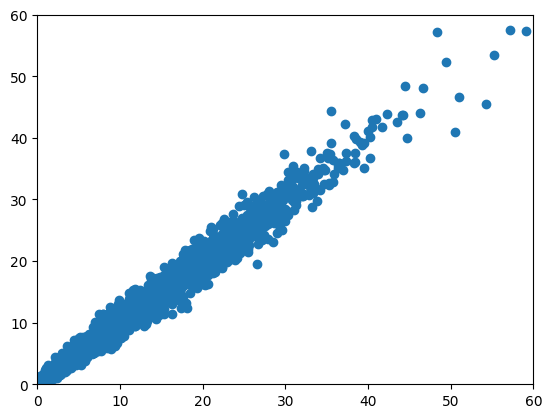

In [17]:
bikein_for_all_station1 = []
for i in range(number_of_station):
    # extract all the rows from df with a specific given station_id
    one_station = df[df['end_station_id'] == all_station_id[i]]
    hourly_bikein_counts = one_station['hour_of_day_end'].value_counts(
    ).sort_index()
    all_hours = list(range(0, 24))
    hourly_bikein_counts = hourly_bikein_counts.reindex(
        all_hours, fill_value=0)
    hourly_bikein_count_list = hourly_bikein_counts.tolist()
    average_bikein_rate = [x / 21 for x in hourly_bikein_count_list]
    bikein_for_all_station1.append(average_bikein_rate)
bikein_for_all_station1 = [row[5:] for row in bikein_for_all_station1]
llist1 = [elem for row in bikein_for_all_station1 for elem in row]
llist2 = [elem for row in bikein_for_all_station for elem in row]
plt.scatter(llist1, llist2)
plt.axis([0, 60, 0, 60])

## Function for number of unhappy user

In [18]:
p = 1

In [19]:
def number_of_unhappy_user(i, d, x0, period):
    lambda_i = bikein_for_all_station[i]
    mu_i = bikeout_for_all_station[i]
    lambda_i = [x for x in lambda_i for _ in range(period)]
    mu_i = [x for x in mu_i for _ in range(period)]
    lambda_i = np.array(lambda_i)
    mu_i = np.array(mu_i)
    unhappy_users = 0 
    
    for j in range(len(lambda_i)):
        bike_number_at_end_j = x0 +(lambda_i[j] - mu_i[j])/period
        
        unhappy = max(bike_number_at_end_j, d) -d - \
            min(0, bike_number_at_end_j)
        
        x0 = max(min(bike_number_at_end_j,d),0)
        
        
        unhappy_users +=unhappy
    
        
    return unhappy_users

## Function for Optimal value 

In [20]:
def optimal_x0(i, d,period):
    
    number_of_unhappy_for_all_x0 = []
    for x0 in list(range(d+1)):
        n = number_of_unhappy_user(i, d, x0, period=period)
        
        
        number_of_unhappy_for_all_x0.append(n)
     
    arr = np.array(number_of_unhappy_for_all_x0)
    min_indices = np.where(arr == arr.min())[0]
   
    median_value = math.floor(np.median(min_indices))
    return median_value

## extract a list of d

In [21]:
capacity = [df1.loc[df1['short_name'] == station_id, 'capacity'].values[0]
            for station_id in all_station_id]


## Prediction for the optimal number of bikes in the fleet

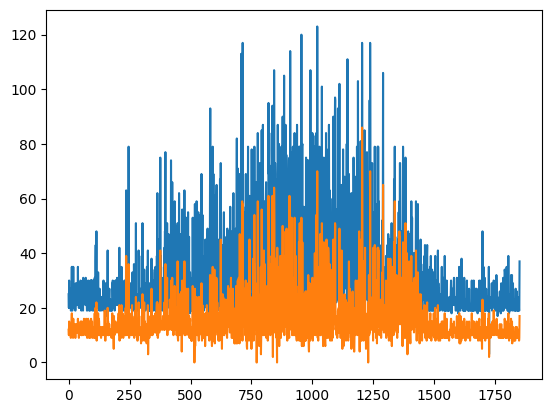

In [22]:
Optimal_values = []
for i in range(number_of_station):
    x = optimal_x0(i, capacity[i],period = p)
    Optimal_values.append(x)
plt.plot(capacity)
plt.plot(Optimal_values)


In [23]:
print(sum(Optimal_values))

29401


## Bikes need to be moved 

In [24]:
def net_flow(i, d, x0, period):
    lambda_i = bikein_for_all_station[i]
    mu_i = bikeout_for_all_station[i]
    lambda_i = [x for x in lambda_i for _ in range(period)]
    mu_i = [x for x in mu_i for _ in range(period)]
    X = [x0]

    for j in range(len(lambda_i)):
        x = min(d, max(0, x0 + 1/period * (lambda_i[j]-mu_i[j])))
        X.append(x)
        x0 = x
    return X[-1] - X[0]

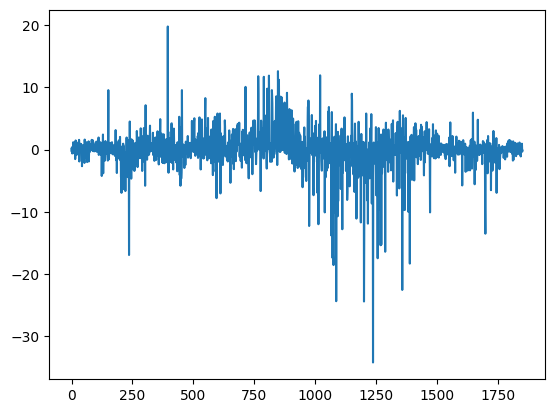

In [25]:
Net_flow = []
for i in range(number_of_station):
    x = net_flow(i, capacity[i], Optimal_values[i], period=p)
    Net_flow.append(x)
plt.plot(Net_flow)


In [26]:
print(sum(Net_flow))

3.8095238095196438


## Predicted number of outages

516 103.23809523809524
771 130.95238095238093
772 148.0952380952381
903 1.0
1229 54.90476190476191


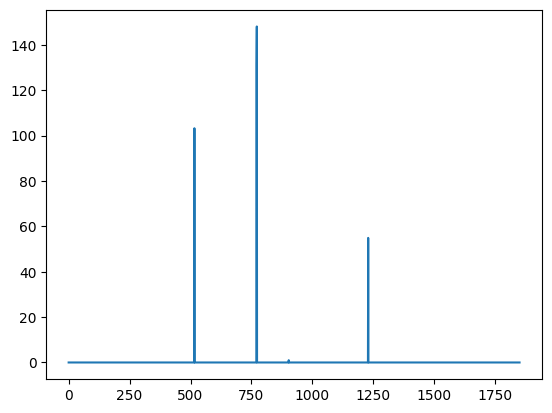

In [27]:
number_of_outage = []
for i in range(number_of_station):
    x = number_of_unhappy_user(i, capacity[i], Optimal_values[i], period=p)
    number_of_outage.append(x)
    if  x > 0 :
        print(i,x)
plt.plot(number_of_outage)

In [28]:
print(sum(number_of_outage))

438.1904761904762


## Points Values

In [29]:
def number_of_unhappy_user_till_end(i, d, x0, t,period=p):
    lambda_i = bikein_for_all_station[i][t-5:]
    mu_i = bikeout_for_all_station[i][t-5:]
    lambda_i = [x for x in lambda_i for _ in range(period)]
    mu_i = [x for x in mu_i for _ in range(period)]
    X = [x0]
    for j in range(len(lambda_i)):
        x = min(d, max(0, x0 + 1/period * (lambda_i[j]-mu_i[j])))
        X.append(x)
        x0 = x
    y = 0
    for j in range(len(lambda_i)):
        y_j = max(X[j]+1/period*(lambda_i[j]-mu_i[j])-d, 0) - \
            min(0, X[j]+1/period*(lambda_i[j]-mu_i[j]))
        
        y = y+y_j
    return y

In [30]:
status_at_2pm = [x // 2 for x in capacity]

In [31]:
def Point(t,status, period ):
    
    Point = []
    for i in range(number_of_station):
        a = number_of_unhappy_user_till_end(i, capacity[i], status[i]-1,t, period=period)
        b = number_of_unhappy_user_till_end(i, capacity[i], status[i], t, period=period)
        c = number_of_unhappy_user_till_end(i, capacity[i], status[i]+1,t,  period=period)
        if b == min(a,b,c):
        
            Point.append(0)
        elif a == min(a,b,c):
            Point.append(a-b)
        else:
            Point.append(b-c)

    return Point

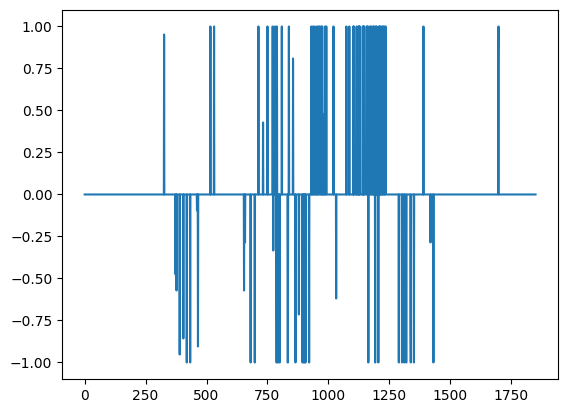

In [32]:
plt.plot(Point(14,status_at_2pm, period = p))

In [152]:
non_numeric_values1 # data in NJ (in blue)
all_station_id # correct data (in black)
difference # data in df0 but not in capacity data (in red)
difference1 # data in df1 but not df0 (in pink)


[6146.01,
 6660.07,
 6660.05,
 'HB301',
 'JC055',
 6155.03,
 6668.06,
 'JC027',
 8212.01,
 6677.03,
 'JC095',
 6171.02,
 'HB505',
 6683.01,
 'JC035',
 'JC008',
 8741.01,
 6180.05,
 'JC115',
 6692.03,
 3113.1,
 6188.04,
 6701.05,
 7727.08,
 8756.07,
 6709.05,
 6198.03,
 'JC072',
 8248.05,
 6709.01,
 6718.02,
 6207.06,
 3648.08,
 'JC074',
 6724.01,
 6213.01,
 6727.02,
 8776.02,
 'JC098',
 3148.09,
 6733.01,
 6222.04,
 'HB203',
 8272.01,
 8272.08,
 8786.01,
 'HB202',
 'HB101',
 'JC077',
 'JC014',
 6231.01,
 6741.03,
 7256.01,
 'JC024',
 6748.04,
 6239.08,
 6240.05,
 'JC075',
 8802.05,
 'JC097',
 6757.03,
 8806.01,
 3688.06,
 'JC110',
 'JC003',
 6248.08,
 6249.02,
 'HB506',
 6763.08,
 8815.01,
 'JC063',
 'JC093',
 8306.03,
 6255.02,
 6258.02,
 6772.11,
 'JC081',
 'JC103',
 6264.06,
 8828.02,
 6780.06,
 8831.03,
 6273.03,
 8835.05,
 6787.02,
 8325.08,
 8325.12,
 3719.02,
 6793.01,
 8330.05,
 'JC102',
 8335.02,
 6287.02,
 8849.03,
 6290.06,
 6290.13,
 6295.07,
 8346.06,
 8859.03,
 6810.01,
 

In [208]:
data0 = pd.read_csv('202307-citibike-tripdata.csv')
df0_all = pd.DataFrame(data0)
df0_all['start_station_id'] = [float(num_str) if str(num_str).replace(
    '.', '', 1).isdigit() else num_str for num_str in df0_all['start_station_id']]
df0_all['end_station_id'] = [float(num_str) if str(num_str).replace(
    '.', '', 1).isdigit() else num_str for num_str in df0_all['end_station_id']]

/var/folders/kd/fd9nkzkd44lc1yw7pn5qkljc0000gn/T/ipykernel_21442/1735465058.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data0 = pd.read_csv('202307-citibike-tripdata.csv')


In [209]:
start_stations_in_df0 = df0_all[['start_station_id', 'start_lat', 'start_lng']].copy().drop_duplicates(['start_station_id'])
start_stations_in_df0.rename(columns={'start_station_id': 'short_name', 'start_lat': 'lat', 'start_lng':'lon'}, inplace=True)

end_stations_in_df0 = df0_all[['end_station_id', 'end_lat', 'end_lng']].copy().drop_duplicates(['end_station_id'])
end_stations_in_df0.rename(columns={'end_station_id': 'short_name', 'end_lat': 'lat', 'end_lng':'lon'}, inplace=True)

stations_in_df0 = pd.concat([start_stations_in_df0, end_stations_in_df0], ignore_index=True).drop_duplicates('short_name').reset_index(drop=True)
stations_in_df0

,short_name,lat,lon
0,7756.1,40.811432,-73.951878
1,7670.09,40.804372,-73.951475
2,8033.09,40.827075,-73.945909
3,7981.16,40.824814,-73.951868
4,7286.01,40.781257,-73.949838
...,...,...,...
1948,190 Morgan,40.711072,-73.932096
1949,JC076,40.721630,-74.049968
1950,HB202,40.752961,-74.024353
1951,JC095,40.722104,-74.071455


In [210]:
df_non_numeric = df1[df1['short_name'].isin(non_numeric_values1)].sort_values(by='short_name').reset_index()[['short_name','lat','lon']]
df_non_numeric['tag'] = 'non_numeric'
df_non_numeric

,short_name,lat,lon,tag
0,HB101,40.735938,-74.030305,non_numeric
1,HB102,40.736068,-74.029127,non_numeric
2,HB103,40.736982,-74.027781,non_numeric
3,HB105,40.737360,-74.030970,non_numeric
4,HB201,40.750604,-74.024020,non_numeric
...,...,...,...,...
65,JC105,40.735208,-74.046964,non_numeric
66,JC109,40.731009,-74.064437,non_numeric
67,JC110,40.715391,-74.049692,non_numeric
68,JC115,40.719410,-74.043090,non_numeric


In [211]:
df_stations = df1[df1['short_name'].isin(all_station_id)].sort_values(by='short_name').reset_index()[['short_name','lat','lon']]
df_stations['tag'] = 'all_stations'
df_stations.shape

(1851, 4)

In [212]:
df_difference = stations_in_df0[stations_in_df0['short_name'].isin(difference)].sort_values(by='short_name').reset_index()[['short_name','lat','lon']]
df_difference['tag'] = 'diff'
df_difference.shape

(20, 4)

In [213]:
df_difference1 = df1[df1['short_name'].isin(difference1)].reset_index()[['short_name','lat','lon']]
df_difference1['tag'] = 'diff1'
df_difference1.shape

(298, 4)

In [223]:
# Show the point value on NYC map
from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import (Circle, MultiLine, StaticLayoutProvider,ColumnDataSource)

def plotStations(dfn, title='Plot of Graph'):
    """
    Plots a static map of a Citi Bike Station.
    :param nodes: pandas df with 'name', 'x', 'y' cols
                  'x' and 'y' treated as mercator coords
    :param title: str of graph title
    """
    # extract data
    node_ids = dfn.short_name.values.tolist()
    x = dfn.x.values.tolist()
    y = dfn.y.values.tolist()
    
    # get plot boundaries
    min_x, max_x = min(dfn.x)+2000, max(dfn.x)-2000
    min_y, max_y = min(dfn.y)+2000, max(dfn.y)-2000

    # show the gird of the graph
    plot = figure(x_range=(min_x, max_x), y_range=(min_y, max_y),
                  x_axis_type="mercator", y_axis_type="mercator",
                  title=title,
                  width=600, height=420,
                  toolbar_location=None, tools=[])

    # get NY map
    plot.add_tile(get_provider(Vendors.CARTODBPOSITRON_RETINA))
    
    # add nodes
    for i in range(dfn.shape[0]):
        if dfn['tag'][i] == 'non_numeric':  
            source = ColumnDataSource(dfn.iloc[i:i+1])
            poi = Circle(x="x", y="y", size=2.5, line_color='white',
                         fill_color="blue", line_width=0.1,fill_alpha = 1)
            plot.add_glyph(source, poi)
        elif dfn['tag'][i] == 'all_stations':  
            source = ColumnDataSource(dfn.iloc[i:i+1])
            poi = Circle(x="x", y="y", size=2.5, line_color='white',
                         fill_color="black", line_width=0.1, fill_alpha = 1)
            plot.add_glyph(source, poi)
        elif dfn['tag'][i] == 'diff':  
            source = ColumnDataSource(dfn.iloc[i:i+1])
            poi = Circle(x="x", y="y", size=4.5, line_color='white',
                         fill_color="red", line_width=0.1,fill_alpha = 0)
            plot.add_glyph(source, poi)
        else:  
            source = ColumnDataSource(dfn.iloc[i:i+1])
            poi = Circle(x="x", y="y", size=4.5, line_color='white',
                         fill_color="green", line_width=0.1,fill_alpha = 0)
            plot.add_glyph(source, poi)
            
    show(plot)

In [215]:
wgs84 = Proj(init='epsg:4326')  # WGS84 coordinate system (latitude and longitude)
mercator = Proj(init='epsg:3857')  # Mercator coordinate system

df_plot = pd.concat([df_non_numeric, df_stations, df_difference, df_difference1], ignore_index=True)
#df_plot = stations_in_df0
df_plot[['x', 'y']] = df_plot.apply(lambda row: transform(wgs84, mercator, row['lon'], row['lat']), axis=1, result_type='expand')


In [224]:
plotStations(df_plot, title="NYC Citi Bike Stations")

In [150]:
df_plot

,short_name,lat,lon,tag,x,y
0,7756.1,40.811432,-73.951878,plot,-8.232285e+06,4.984568e+06
1,7670.09,40.804372,-73.951475,plot,-8.232241e+06,4.983529e+06
2,8033.09,40.827075,-73.945909,plot,-8.231621e+06,4.986869e+06
3,7981.16,40.824814,-73.951868,plot,-8.232284e+06,4.986536e+06
4,7286.01,40.781257,-73.949838,plot,-8.232058e+06,4.980130e+06
...,...,...,...,...,...,...
1948,190 Morgan,40.711072,-73.932096,plot,-8.230083e+06,4.969818e+06
1949,JC076,40.721630,-74.049968,plot,-8.243205e+06,4.971368e+06
1950,HB202,40.752961,-74.024353,plot,-8.240353e+06,4.975971e+06
1951,JC095,40.722104,-74.071455,plot,-8.245597e+06,4.971438e+06


In [138]:
df0[df0['start_station_id']=='HB101']

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1585926,1850E34F47014689,classic_bike,2023-07-14 17:08:32,2023-07-14 17:13:19,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Hoboken Ave at Monmouth St,JC105,40.709700,-73.931225,40.735208,-74.046964,casual
1712746,F7894FD9117F3812,classic_bike,2023-07-11 08:26:41,2023-07-11 08:35:19,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Washington St,JC098,40.706883,-74.005536,40.724294,-74.035483,casual
3477041,944410E7BC4B4395,classic_bike,2023-07-12 10:21:40,2023-07-12 10:26:29,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Southwest Park - Jackson St & Observer Hwy,HB401,40.728355,-74.011732,40.737551,-74.041664,member
